## Non-linear Regression

In [6]:
#!pip3 install catboost

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [18]:

# Importing prepared dataset
import pickle
input = open('data_reg.pkl', 'rb')
obj = pickle.load(input)
input.close()
X_train = obj["X_train"]
X_test = obj["X_test"]
y_train = obj["y_train"]
y_test = obj["y_test"]

f = ['NumWebVisitsMonth','all_Response','all_Purchases']

Выбрала 3 поля, которые оказывают наибольшее влияние на прогнозирование дохода клинента.

In [19]:
from math import sqrt
def metrics(X_train, X_test, y_train, y_test, y_pred, model):
    RMSE = [sqrt(mean_squared_error(y_train, model.predict(X_train))), sqrt(mean_squared_error(y_test, y_pred))]
    R2 = [model.score(X_train, y_train), model.score(X_test, y_test)]
    results = {'RMSE': RMSE, 'R2':R2}
    return pd.DataFrame(results, index=['Train', 'Test'])

## Regression Tree

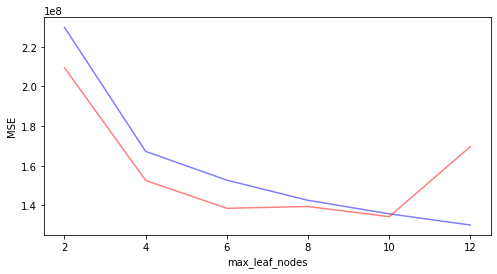

In [21]:
def max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        dt = DecisionTreeRegressor(max_leaf_nodes = i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, dt.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, dt.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")
    
# The optimal number of max_leaf_nodes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
max_leaf_nodes(X_train[f], X_test[f], y_train, y_test, [2, 4, 6, 8, 10, 12])

До 4х "листиков" на дереве качество модели улучшается, после также, но уже темп не такой сильный где-то с 8-10.
Буду считать, что оптимальной глубиной дерева будет кол-во 8.

In [26]:
# Fitting Tree to the Training set
dt = DecisionTreeRegressor(max_leaf_nodes = 8).fit(X_train[f], y_train)

# Predicting the Test set results
dt_y_pred = dt.predict(X_test[f])

# Metrics
metrics(X_train[f], X_test[f], y_train, y_test, dt_y_pred, dt).round(2)

,RMSE,R2
Train,11942.05,0.68
Test,11810.86,0.66


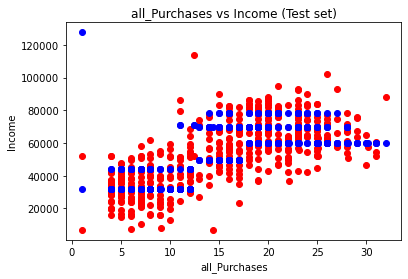

In [27]:

# Visualising the Test set results
plt.scatter(X_test['all_Purchases'], y_test, color = 'red')
plt.plot(X_test['all_Purchases'], dt.predict(X_test[f]), 'bo')
plt.title('all_Purchases vs Income (Test set)')
plt.xlabel('all_Purchases')
plt.ylabel('Income')
plt.show()

Text(0.5, 1.0, 'Tree. Feature Importance')

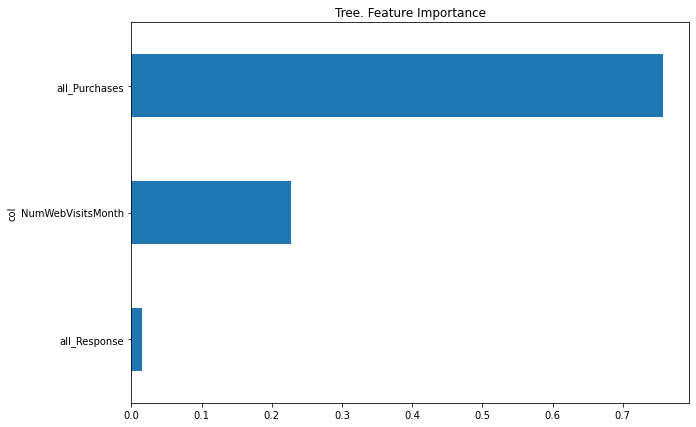

In [28]:
# Features importances
dt_imp = pd.DataFrame({'imp': dt.feature_importances_, 'col': X_train[f].columns})
dt_imp = dt_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
dt_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Tree. Feature Importance')

На данной визуализации видно, что в значительной мере при построении дерева повлиял параметр кол-во покупок в магазине, вторым было кол-во визитов на сайт данного продуктового магазина, и почти не был задействован параметр кол-ва покупок.

## Random Forest

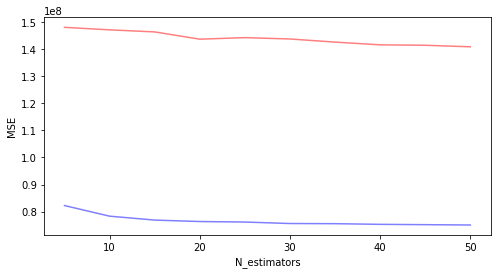

In [29]:
def rf_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("N_estimators")
    
# The optimal number of trees 
from sklearn.ensemble import RandomForestRegressor    
rf_best_n_estimator(X_train[f], X_test[f], y_train, y_test, [5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

Ошибка тестирования сильно превышает ошибку обучения при любых вариантах - модель будет сильно переучена.

20 деревьев вполне достаточно для данной выборки.

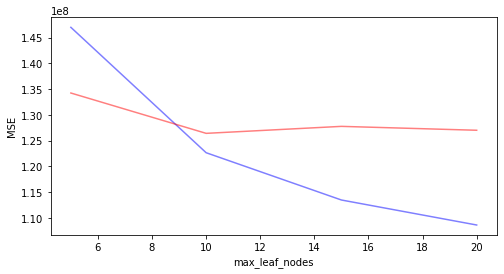

In [30]:
def rf_max_leaf_nodes(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        rf = RandomForestRegressor(n_estimators=20, max_leaf_nodes =i, random_state=10).fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, rf.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, rf.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_leaf_nodes")
    
# The optimal number of max_leaf_nodes
rf_max_leaf_nodes(X_train[f], X_test[f], y_train, y_test, [5, 10, 15, 20])

Сильное изменение происходит при 9 "листиках", т.к. разница в ошибках между обучающей и тестовой не такая сильная, как далее можно увидеть на графике, но уже после 9 "листиков" улучшение качества не есть столь значимым.

In [31]:
# Fitting Random Forest to the Training set
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 20, max_leaf_nodes = 9, random_state = 10).fit(X_train[f], y_train)

# Predicting the Test set results
rf_y_pred = rf.predict(X_test[f])

# Metrics
metrics(X_train[f], X_test[f], y_train, y_test, rf_y_pred, rf).round(2)

,RMSE,R2
Train,11224.59,0.72
Test,11332.16,0.69


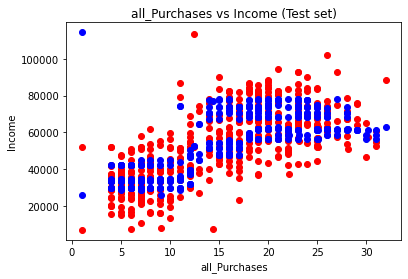

In [32]:
# Visualising the Test set results
plt.scatter(X_test['all_Purchases'], y_test, color = 'red')
plt.plot(X_test['all_Purchases'], rf.predict(X_test[f]), 'bo')
plt.title('all_Purchases vs Income (Test set)')
plt.xlabel('all_Purchases')
plt.ylabel('Income')
plt.show()

Text(0.5, 1.0, 'Random Forest. Feature Importance')

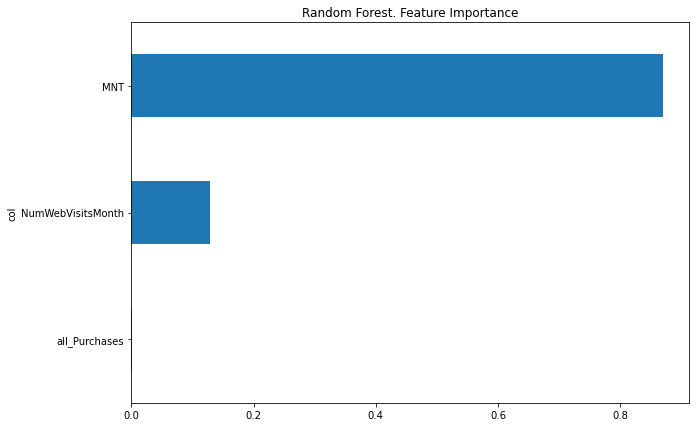

In [26]:
# Features importances
rf_imp = pd.DataFrame({'imp': rf.feature_importances_, 'col': X_train[f].columns})
rf_imp = rf_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
rf_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Random Forest. Feature Importance')

## CatBoost

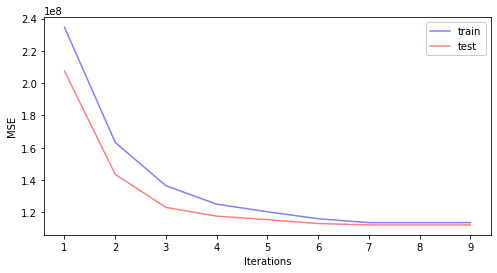

In [33]:
def catboost_best_n_estimator(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train, y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Iterations')
    ax.legend(framealpha=1, frameon=True);
    
from catboost import CatBoostRegressor
catboost_best_n_estimator(X_train[f], X_test[f], y_train, y_test, list(range(1,10)))

7ти итерации будет вполне достаточно, для улучшения показателей качества модели.

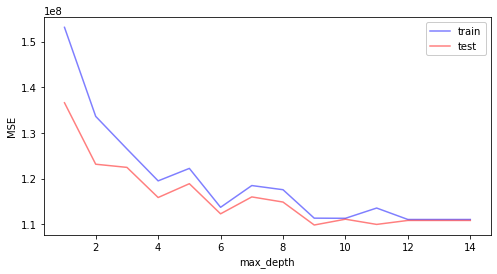

In [34]:
def catboost_max_depth(X_train, X_test, y_train, y_test, n):
    mse_train = []
    mse_test = []
    for i in n:
        catboost = CatBoostRegressor(iterations=7,max_depth=i,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train,y_train,eval_set=(X_test, y_test),logging_level='Silent')
        mse_train.append(mean_squared_error(y_train, catboost.predict(X_train)))
        mse_test.append(mean_squared_error(y_test, catboost.predict(X_test)))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(n, mse_train, alpha=0.5, color='blue', label='train')
    ax.plot(n, mse_test, alpha=0.5, color='red', label='test')
    ax.set_ylabel("MSE")
    ax.set_xlabel("max_depth")
    ax.legend(framealpha=1, frameon=True);

catboost_max_depth(X_train[f], X_test[f], y_train, y_test, list(range(1,15)))

Глубину я бы пробовала 12, т.к. у обучающей и тестовой выборок в этой точке минимальное кол-во ошибок.

In [36]:
# Fitting CatBoost to the Training set
cb = CatBoostRegressor(iterations=7,max_depth=12,random_state=10,eval_metric='RMSE',loss_function='RMSE').fit(X_train[f], y_train,eval_set=(X_test[f], y_test),logging_level='Silent')

# Predicting the Test set results
cb_y_pred = cb.predict(X_test[f])

# Metrics
metrics(X_train[f], X_test[f], y_train, y_test, cb_y_pred, cb).round(2)

,RMSE,R2
Train,10537.29,0.75
Test,10527.31,0.73


Text(0.5, 1.0, 'Boosting. Feature Importance')

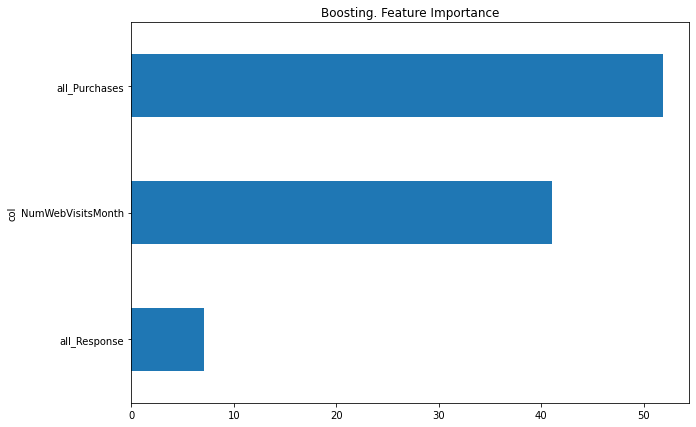

In [37]:
# Features importances
cb_imp = pd.DataFrame({'imp': cb.get_feature_importance(), 'col': X_train[f].columns})
cb_imp = cb_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-25:]
cb_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Boosting. Feature Importance')

В построении модели методом CatBoosting повлияли почти в равной степени кол-во визитов на сайт магазина и сумма покупок товаров.

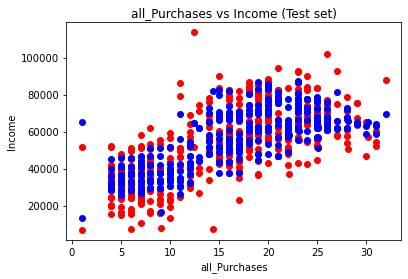

In [38]:
# Visualising the Test set results
plt.scatter(X_test['all_Purchases'], y_test, color = 'red')
plt.plot(X_test['all_Purchases'], cb.predict(X_test[f]), 'bo')
plt.title('all_Purchases vs Income (Test set)')
plt.xlabel('all_Purchases')
plt.ylabel('Income')
plt.show()


In [39]:
# Metrics
metric_dt = metrics(X_train[f], X_test[f], y_train,y_test, dt_y_pred, dt).round(2).abs()
metric_dt['Type'] = 'Tree'

metric_rf = metrics(X_train[f], X_test[f], y_train,y_test,  rf_y_pred, rf).round(2).abs()
metric_rf['Type'] = 'Random forest'

metric_cb = metrics(X_train[f], X_test[f], y_train,y_test, cb_y_pred, cb).round(2)
metric_cb['Type'] = 'Catboost'

metric = pd.concat([metric_dt,metric_rf,metric_cb])
metric

,RMSE,R2,Type
Train,11942.05,0.68,Tree
Test,11810.86,0.66,Tree
Train,11224.59,0.72,Random forest
Test,11332.16,0.69,Random forest
Train,10537.29,0.75,Catboost
Test,10527.31,0.73,Catboost


Конечно, заметно улучшение моделей при использовании разных методов. Безусловно, Catboost дал лучшие результаты в сравнении с другими моделями и по R2 и по ошибкам на обучающей и тестовой выборках.